# Tune the meta model
 
We want to check if we can exchange the metamodel from Ridge to DNN

We use the best base model parameters from the previous notebooks

# Model v4.1 - Baseline model with MA02 DNN as base estimator

In [7]:
import pandas as pd

from data import load_data_selected_features

train_data, additional_train_data, test_data = load_data_selected_features()

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150996 entries, p01_0 to p12_25298
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 585.2+ MB


In [9]:
additional_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168588 entries, p01_test_12 to p24_test_94938
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 657.4+ MB


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [11]:
from pipelines_selected_features import pipeline

all_train_data = pd.concat([train_data, additional_train_data], axis=0)
all_train_data_transformed = pipeline.fit_transform(all_train_data)

train_data_transformed = all_train_data_transformed[:len(train_data)]
additional_train_data_transformed = all_train_data_transformed[len(train_data):]

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

X_additional_train = additional_train_data_transformed.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data_transformed['bg+1:00']

## Predict for validation data and check results

Pretrain with train data
Epoch 1/65
7990/7990 - 22s - 3ms/step - loss: 7.4078 - rmse: 2.5463 - val_loss: 5.1340 - val_rmse: 2.0099
Epoch 2/65
7990/7990 - 23s - 3ms/step - loss: 4.8493 - rmse: 2.1725 - val_loss: 5.0126 - val_rmse: 1.9737
Epoch 3/65
7990/7990 - 21s - 3ms/step - loss: 4.6275 - rmse: 2.1223 - val_loss: 5.0652 - val_rmse: 1.9878
Epoch 4/65
7990/7990 - 19s - 2ms/step - loss: 4.4884 - rmse: 2.0902 - val_loss: 4.8702 - val_rmse: 1.9625
Epoch 5/65
7990/7990 - 24s - 3ms/step - loss: 4.4196 - rmse: 2.0735 - val_loss: 5.1008 - val_rmse: 1.9900
Epoch 6/65
7990/7990 - 23s - 3ms/step - loss: 4.3168 - rmse: 2.0493 - val_loss: 5.0503 - val_rmse: 1.9850
Epoch 7/65
7990/7990 - 20s - 3ms/step - loss: 4.2461 - rmse: 2.0331 - val_loss: 5.2178 - val_rmse: 2.0101
Epoch 8/65
7990/7990 - 20s - 3ms/step - loss: 4.2073 - rmse: 2.0227 - val_loss: 5.0007 - val_rmse: 1.9795
Epoch 9/65
7990/7990 - 20s - 3ms/step - loss: 4.1739 - rmse: 2.0146 - val_loss: 5.4604 - val_rmse: 2.0429
Epoch 10/65
7990/7990

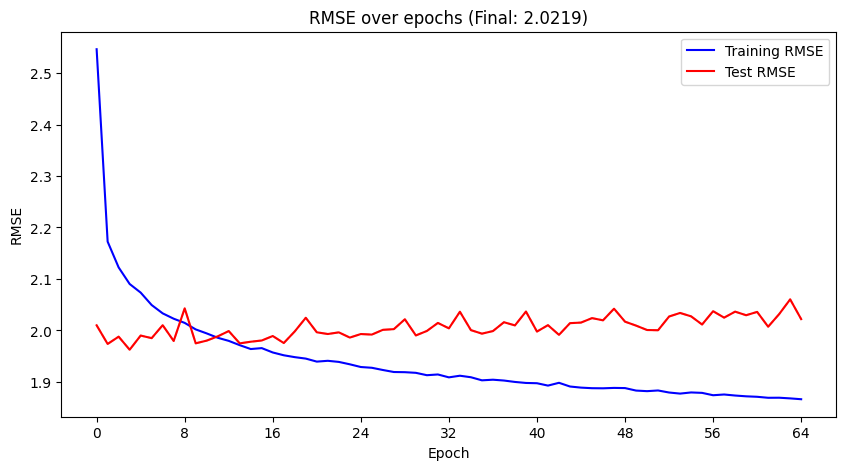

In [12]:
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from model_performance_calculations import get_history_line_chart


def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def create_dnn_model(input_dimension: int):
    dnn = Sequential([
        # Input layer
        Input(shape=(input_dimension,)),

        # First dense block
        Dense(512, activation='relu'),  # Increased neurons
        BatchNormalization(),
        Dropout(0.3),  # Slightly reduced dropout for better capacity

        # Second dense block
        Dense(256, activation='relu'),  # Increased neurons
        BatchNormalization(),
        Dropout(0.3),

        # Third dense block
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Fourth dense block (new)
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer
        Dense(1, activation='linear')  # Regression output
    ])

    # Compile the model
    dnn.compile(
        optimizer=Adam(learning_rate=0.001),  # Retained learning rate
        loss='mse',  # Mean Squared Error for regression
        metrics=[rmse]  # Custom RMSE metric
    )

    return dnn


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights('v4.1-MA02.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(optimizer='adam', loss='mse', metrics=[rmse])
    return dnn


pretrained_dnn = create_dnn_model(X_train.shape[1])

print('Pretrain with train data')
pretrained_dnn.fit(
    pd.concat([X_train, X_additional_train], axis=0),
    pd.concat([y_train, y_additional_train], axis=0),
    validation_split=0.2,
    batch_size=32,
    epochs=65,
    verbose=2
)

history = pretrained_dnn.history.history

print('Pretrain save weights')
pretrained_dnn.save_weights('v4.1-MA02.weights.h5')
get_history_line_chart([history]).show()

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge

hgb_estimator = HistGradientBoostingRegressor(
    max_iter=200,
    max_depth=5,
    learning_rate=0.1
)

knn_estimator = KNeighborsRegressor(
    leaf_size=30,
    metric='minkowski',
    n_neighbors=7,
    p=2,
    weights='uniform'
)

lasso_lars_ic_base_estimator = LassoLarsIC(
    criterion='aic',
    eps=0.03922948513965659,
    max_iter=1944,
    noise_variance=5.4116687755186035e-05,
    positive=False,
)

xgb_estimator = XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.05,
    min_child_weight=6,
    colsample_bytree=0.8,
    subsample=0.8,
    gamma=1,
    reg_lambda=10.0,
    reg_alpha=1.0,
    objective='reg:squarederror',
    random_state=42,
)

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', hgb_estimator),
    ('lasso_lars_ic', lasso_lars_ic_base_estimator),
    ('knn', knn_estimator),
    ('xgb', xgb_estimator),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

14:58:11 - Start training
14:58:11 - Calculate performance for hgb
14:58:11 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
14:58:11 - Split 1 - Model: hgb
14:58:12 - Fitting the model
14:58:20 - Predicting
14:58:20 - Calculating scores
14:58:20 - R^2: 0.6169400833548542, RMSE: 2.028574930660201, MAE: 1.5085261184967733, MSE: 4.115116249303038
14:58:20 - Split 2 - Model: hgb
14:58:20 - Fitting the model
14:58:30 - Predicting
14:58:30 - Calculating scores
14:58:30 - R^2: 0.6125333551504599, RMSE: 2.043490987849192, MAE: 1.5232236829052834, MSE: 4.175855417420866
14:58:30 - Split 3 - Model: hgb
14:58:30 - Fitting the model
14:58:38 - Predicting
14:58:38 - Calculating scores
14:58:38 - R^2: 0.61607813175661, RMSE: 2.013543729180387, MAE: 1.5032678990961286, MSE: 4.054358349321659
14:58:38 - Split 4 - Model: hgb
14:58:38 - Fitting the model
14:58:51 - Predicting
14:58:51 - Calculating scores
14:58:51 - R^2: 0.6140872282969334, RMSE: 2.04230244

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 7s - 731us/step - loss: 3.6983 - rmse: 3.8189
15:02:05 - Predicting
1054/1054 - 1s - 780us/step
15:02:06 - Calculating scores
15:02:06 - R^2: 0.6289432788793903, RMSE: 1.9965392411830314, MAE: 1.4641129700089204, MSE: 3.9861689415837147
15:02:06 - Split 2 - Model: dnn
15:02:06 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 9s - 1ms/step - loss: 3.6971 - rmse: 3.8188
15:02:15 - Predicting
1054/1054 - 1s - 900us/step
15:02:16 - Calculating scores
15:02:16 - R^2: 0.6284023596902071, RMSE: 2.001207120291678, MAE: 1.4807876133744815, MSE: 4.004829938306111
15:02:16 - Split 3 - Model: dnn
15:02:16 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 7s - 814us/step - loss: 3.7102 - rmse: 3.8247
15:02:24 - Predicting
1054/1054 - 1s - 714us/step
15:02:25 - Calculating scores
15:02:25 - R^2: 0.6289032804969256, RMSE: 1.9796262242067852, MAE: 1.464385803093003, MSE: 3.918919987567213
15:02:25 - Split 4 - Model: dnn
15:02:25 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 7s - 807us/step - loss: 3.7126 - rmse: 3.8190
15:02:32 - Predicting
1054/1054 - 1s - 910us/step
15:02:34 - Calculating scores
15:02:34 - R^2: 0.6278432897988728, RMSE: 2.0055726983668243, MAE: 1.4803462735655837, MSE: 4.022321848434385
15:02:34 - Split 5 - Model: dnn
15:02:34 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 7s - 796us/step - loss: 3.6956 - rmse: 3.8205
15:02:41 - Predicting
1054/1054 - 1s - 878us/step
15:02:42 - Calculating scores
15:02:42 - R^2: 0.6212530664503579, RMSE: 1.9976321493634974, MAE: 1.4724831434209489, MSE: 3.9905342041706264
15:02:42 - Training finished
15:02:42 - Calculate performance for final_estimator
15:02:42 - Selected splitter: ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None)
15:02:42 - Split 1 - Model: final_estimator
15:02:42 - Fitting the model
15:02:43 - Predicting
15:02:43 - Calculating scores
15:02:43 - R^2: 0.550473788739431, RMSE: 2.197532006476215, MAE: 1.6465811248386755, MSE: 4.829146919487378
15:02:43 - Split 2 - Model: final_estimator
15:02:43 - Fitting the model
15:02:43 - Predicting
15:02:43 - Calculating scores
15:02:43 - R^2: 0.5482085682464537, RMSE: 2.20660481139947, MAE: 1.6617115145586885, MSE: 4.86910479369129
15:02:43 - Split 3 - Model: final_estimator
15:02:43 - Fitting the model
15:02:43 - Predicting
15:02

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 12s - 1ms/step - loss: 3.7167 - rmse: 3.8174


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 8s - 1ms/step - loss: 3.6842 - rmse: 3.8694
1787/1787 - 2s - 905us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 10s - 1ms/step - loss: 3.9185 - rmse: 3.8497
1787/1787 - 7s - 4ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 15s - 2ms/step - loss: 3.8355 - rmse: 3.8323
1787/1787 - 4s - 2ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 11s - 2ms/step - loss: 3.5417 - rmse: 3.7660
1787/1787 - 2s - 1ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 13s - 2ms/step - loss: 3.5651 - rmse: 3.7654
1787/1787 - 3s - 2ms/step
15:09:19 - Predicting
1054/1054 - 1s - 1ms/step
15:09:30 - Calculating scores
15:09:30 - R^2: 0.6700546804574188, RMSE: 1.8826894338189744, MAE: 1.3741566595760384, MSE: 3.54451950421361
15:09:30 - Split 2 - Model: stacking_regressor
15:09:30 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 23s - 3ms/step - loss: 3.7032 - rmse: 3.8187


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 13s - 2ms/step - loss: 3.6777 - rmse: 3.8653
1787/1787 - 2s - 1ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 13s - 2ms/step - loss: 3.9105 - rmse: 3.8468
1787/1787 - 3s - 2ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 12s - 2ms/step - loss: 3.8364 - rmse: 3.8200
1787/1787 - 2s - 1ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 24s - 3ms/step - loss: 3.5509 - rmse: 3.7680
1787/1787 - 6s - 3ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 29s - 4ms/step - loss: 3.5469 - rmse: 3.7720
1787/1787 - 7s - 4ms/step
15:16:54 - Predicting
1054/1054 - 2s - 1ms/step
15:17:06 - Calculating scores
15:17:06 - R^2: 0.6705467527026934, RMSE: 1.884310473134677, MAE: 1.3885528590633933, MSE: 3.5506259591650298
15:17:06 - Split 3 - Model: stacking_regressor
15:17:06 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 9s - 1ms/step - loss: 3.7093 - rmse: 3.8214


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 8s - 1ms/step - loss: 3.7036 - rmse: 3.8726
1787/1787 - 2s - 973us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 15s - 2ms/step - loss: 3.9439 - rmse: 3.8515
1787/1787 - 4s - 2ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 21s - 3ms/step - loss: 3.8254 - rmse: 3.8312
1787/1787 - 3s - 2ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 22s - 3ms/step - loss: 3.5384 - rmse: 3.7651
1787/1787 - 2s - 1ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 9s - 1ms/step - loss: 3.5902 - rmse: 3.7783
1787/1787 - 2s - 937us/step
15:22:35 - Predicting
1054/1054 - 1s - 1ms/step
15:22:46 - Calculating scores
15:22:46 - R^2: 0.6689863980352546, RMSE: 1.8696596729401909, MAE: 1.3760788491032334, MSE: 3.4956272926188214
15:22:46 - Split 4 - Model: stacking_regressor
15:22:46 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 6s - 708us/step - loss: 3.7265 - rmse: 3.8172


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 17s - 2ms/step - loss: 3.6888 - rmse: 3.8666
1787/1787 - 2s - 934us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 9s - 1ms/step - loss: 3.9246 - rmse: 3.8451
1787/1787 - 2s - 1ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 9s - 1ms/step - loss: 3.8262 - rmse: 3.8244
1787/1787 - 1s - 618us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 5s - 703us/step - loss: 3.5377 - rmse: 3.7648
1787/1787 - 1s - 593us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 6s - 770us/step - loss: 3.5735 - rmse: 3.7700
1787/1787 - 1s - 767us/step
15:27:52 - Predicting
1054/1054 - 1s - 632us/step
15:28:03 - Calculating scores
15:28:03 - R^2: 0.6684452244728503, RMSE: 1.893010948657469, MAE: 1.3935637070849245, MSE: 3.583490451737051
15:28:03 - Split 5 - Model: stacking_regressor
15:28:03 - Fitting the model


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


8934/8934 - 14s - 2ms/step - loss: 3.7046 - rmse: 3.8187


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 8s - 1ms/step - loss: 3.6776 - rmse: 3.8720
1787/1787 - 2s - 1ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 13s - 2ms/step - loss: 3.9320 - rmse: 3.8539
1787/1787 - 5s - 3ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 20s - 3ms/step - loss: 3.8281 - rmse: 3.8340
1787/1787 - 4s - 2ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 23s - 3ms/step - loss: 3.5541 - rmse: 3.7638
1787/1787 - 4s - 2ms/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7147/7147 - 17s - 2ms/step - loss: 3.5392 - rmse: 3.7700
1787/1787 - 2s - 1ms/step
15:33:11 - Predicting
1054/1054 - 1s - 953us/step
15:33:23 - Calculating scores
15:33:23 - R^2: 0.6636521266374934, RMSE: 1.8825013624790456, MAE: 1.383511475774381, MSE: 3.543811379735463
15:33:23 - Training finished
Final estimator RMSE: 1.8824343782060715
Final estimator R2: 0.6683370364611421
Final estimator MSE: 3.543614917493995
Final estimator MAE: 1.3831727101203941


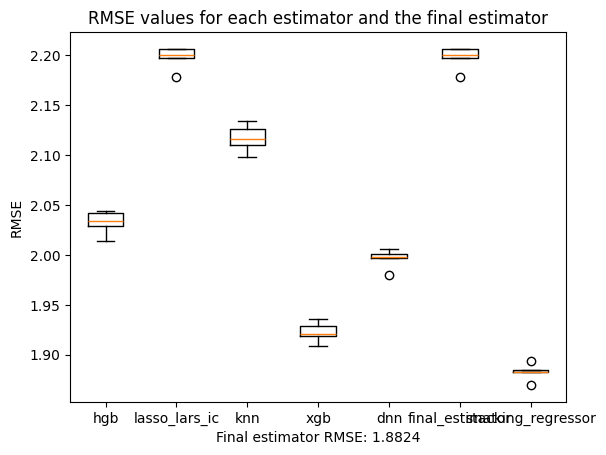

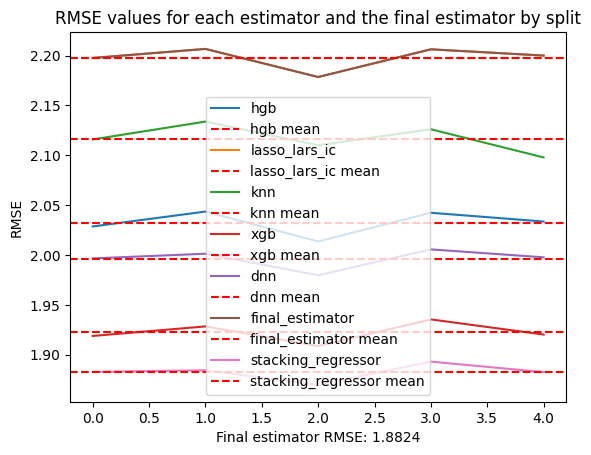

In [14]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_name = f'{date_time}-model-v4.1-DNN'

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, X_additional_train, y_additional_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

In [15]:
import numpy as np
from pipelines_selected_features import pipeline

all_train_data_transformed = pipeline.fit_transform(pd.concat([train_data, additional_train_data], axis=0))

X_train = all_train_data_transformed.drop(columns=['bg+1:00'])
y_train = all_train_data_transformed['bg+1:00']
X_test = pipeline.transform(test_data)

model.fit(X_train, y_train)

/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


9987/9987 - 6s - 570us/step - loss: 3.7683 - rmse: 3.8373


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 609us/step - loss: 3.7848 - rmse: 3.8984
1998/1998 - 1s - 536us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 595us/step - loss: 4.0070 - rmse: 3.8798
1998/1998 - 1s - 536us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 595us/step - loss: 3.8303 - rmse: 3.8249
1998/1998 - 1s - 539us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 625us/step - loss: 3.9378 - rmse: 3.8135
1998/1998 - 1s - 534us/step


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


7990/7990 - 5s - 601us/step - loss: 3.3206 - rmse: 3.7816
1998/1998 - 1s - 535us/step


StackingRegressor(estimators=[('hgb',
                               HistGradientBoostingRegressor(max_depth=5,
                                                             max_iter=200)),
                              ('lasso_lars_ic',
                               LassoLarsIC(eps=0.03922948513965659,
                                           max_iter=1944,
                                           noise_variance=5.4116687755186035e-05)),
                              ('knn', KNeighborsRegressor(n_neighbors=7)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=No...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=6,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('dnn',
                               KerasRegressor(model=<function model_with_pretrained_weights at 0x1150104a0>, verbose=2))],
                  final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

In [16]:
y_pred = model.predict(X_test)
test_data['bg+1:00'] = y_pred

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

114/114 - 0s - 1ms/step


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.761502
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,6.429156
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.039436
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.585248
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.891765


In [17]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission.to_csv(f'submission-{model_name}.csv')
submission

,bg+1:00
id,
p01_8459,8.761502
p01_8460,6.429156
p01_8461,8.039436
p01_8462,11.585248
p01_8463,8.891765
...,...
p24_256,6.634699
p24_257,12.075657
p24_258,6.574203


In [18]:
submission.describe()

,bg+1:00
count,3644.000000
mean,8.525764
std,2.545486
min,3.518073
25%,6.765134
50%,7.965491
75%,9.680452
max,27.306176
